# Scikit-learn
(but really, just some points on some parts of your pipeline)

Note: Parts of this tutorial are lifted verbatim from https://github.com/dssg/hitchhikers-guide/blob/master/curriculum/3_modeling_and_machine_learning/machine-learning/machine_learning_clean.ipynb

## Plan
1. our example dataset
1. what type of ML we'll do
1. generating labels
1. generating features
1. binding features to the labels
1. handing your matrix to sklearn and fitting a model
1. evaluating your model
1. trying more models
1. temporal cross-validation
1. assortment of issues to keep in mind
1. further reading

## Glossary of Terms 
- **Learning**: In machine learning, you'll hear about "learning a model." This is what you probably know as 
*fitting* or *estimating* a function, or *training* or *building* a model. These terms are all synonyms and are 
used interchangeably in the machine learning literature.
- **Examples**: These are what you probably know as *data points* or *observations*. 
- **Features**: These are what you probably know as *independent variables*, *attributes*, *predictors*, 
or *explanatory variables.*
- **Underfitting**: This happens when a model is too simple and does not capture the structure of the data well 
enough.
- **Overfitting**: This happens when a model is too complex or too sensitive to the noise in the data; this can
result in poor generalization performance, or applicability of the model to new data. 
- **Regularization**: This is a general method to avoid overfitting by applying additional constraints to the model. 
For example, you can limit the number of features present in the final model, or the weight coefficients applied
to the (standardized) features are small.
- **Supervised learning** involves problems with one target or outcome variable (continuous or discrete) that we want
to predict, or classify data into. Classification, prediction, and regression fall into this category. We call the
set of explanatory variables $X$ **features**, and the outcome variable of interest $Y$ the **label**.
- **Unsupervised learning** involves problems that do not have a specific outcome variable of interest, but rather
we are looking to understand "natural" patterns or groupings in the data - looking to uncover some structure that 
we do not know about a priori. Clustering is the most common example of unsupervised learning, another example is 
principal components analysis (PCA).


## Setup

In [205]:
import pandas as pd
import numpy as np
import os
import sklearn
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set(font_scale=1.8)
%matplotlib inline

## Example Dataset

We've fetched an open dataset from https://data.cityofchicago.org/Health-Human-Services/Food-Inspections, and restricted it to certain business types. It's saved in the `data/` folder.

`food_2015_2016.csv` is the subset of all inspections that were targeted at restaurants, bakeries, and 'mobile food preparers' that happened in 2015 or 2016. `all_inspected.csv` lists all restaurants, bakeries, and mobile food preparers that have ever been inspected. 

(By the way! The exclamation point (`!`) sends the following command to your system shell. Can be super useful for stuff like `! wget google.com`)

In [206]:
ls data/

all_inspected.csv  food_2015_2016.csv


Let's quickly look at the inspections:

In [207]:
df = pd.read_csv(os.path.join('data','food_2015_2016.csv'), parse_dates=['inspection_date'])
df.head()

,inspection_id,dba_name,aka_name,license_#,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,1758213,COUGAR FUEL,NaN,2464645,Restaurant,Risk 1 (High),3800 W 103RD ST,CHICAGO,IL,60655.0,2016-05-13,License,Not Ready,NaN,41.706088,-87.716077,"(41.706088266160116, -87.71607715391127)"
1,1978676,"WINDY CITY, INN",WINDY CITY INN,47870,Restaurant,Risk 2 (Medium),2255-2257 W IRVING PARK RD,CHICAGO,IL,60618.0,2016-12-27,Canvass,Out of Business,NaN,41.953942,-87.685810,"(41.95394237168946, -87.68581019750351)"
2,1978516,STARBUCKS COFFEE #25092,STARBUCKS COFFEE #25092,2500982,Restaurant,Risk 2 (Medium),875 N MICHIGAN AVE,CHICAGO,IL,60611.0,2016-12-21,License,No Entry,NaN,41.898949,-87.623975,"(41.898948541729865, -87.62397498768968)"
3,1978455,PING PONG,PING PONG,1765705,Restaurant,Risk 1 (High),3322-3326 N BROADWAY,CHICAGO,IL,60657.0,2016-12-20,Suspected Food Poisoning,No Entry,NaN,41.942623,-87.644625,"(41.94262315814179, -87.64462536460103)"
4,1978498,JOY YEE NOODLE SHOP,JOY YEE NOODLE SHOP,2008459,Restaurant,Risk 1 (High),2139 S CHINA PL,CHICAGO,IL,60616.0,2016-12-21,Short Form Complaint,Pass,NaN,41.853788,-87.634715,"(41.85378847066135, -87.63471470519069)"


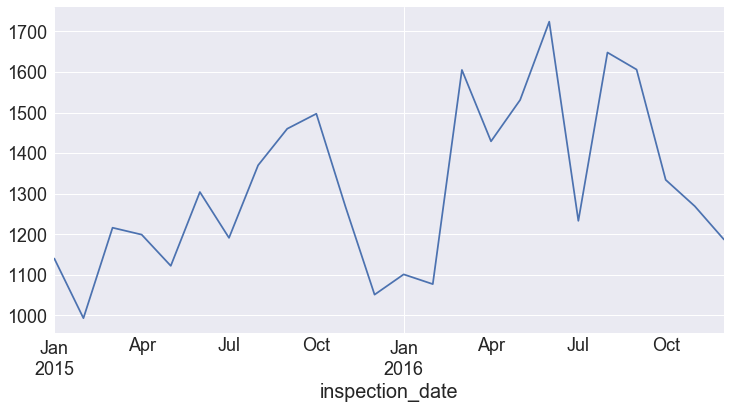

In [208]:
df.set_index('inspection_date')\
    .groupby(pd.TimeGrouper('1M'))\
    .inspection_id.count().plot(figsize=(12,6))

Isn't `TimeGrouper` awesome? You can use it with other column names, too. (Note the 

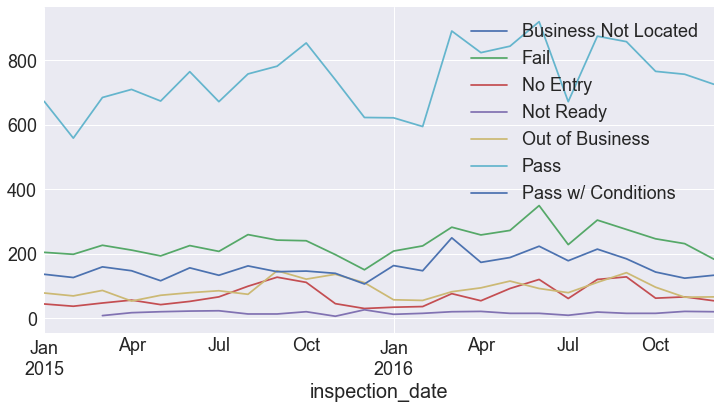

In [209]:
df.set_index('inspection_date')\
    .groupby([pd.TimeGrouper('1M'),'results'])\
    .inspection_id.count().unstack().plot(figsize=(12,6))
plt.legend(loc='upper right')

In [210]:
df.results.value_counts(dropna=False) # dropna=False also counts NaNs

Pass                    17845
Fail                     5636
Pass w/ Conditions       3813
Out of Business          2186
No Entry                 1683
Not Ready                 387
Business Not Located        5
Name: results, dtype: int64

In [211]:
df.results.value_counts(dropna=False, normalize=True)

Pass                    0.565521
Fail                    0.178609
Pass w/ Conditions      0.120837
Out of Business         0.069276
No Entry                0.053335
Not Ready               0.012264
Business Not Located    0.000158
Name: results, dtype: float64

Quick look at the list of all places that were inspected, ever:

In [212]:
businesses = pd.read_csv(os.path.join('data','all_inspected.csv'))

In [213]:
businesses.head()

,dba_name,license_#,facility_type,address,city,state,zip
0,FOUR STAR LOUNGE,2368212,Restaurant,2666-2668 N HALSTED ST,CHICAGO,IL,60614.0
1,TAQUERIA VARGAS,2397411,Restaurant,7152 N CALIFORNIA AVE,CHICAGO,IL,60645.0
2,MEI SHUNG RESTAURANT,1579243,Restaurant,5511 N BROADWAY,CHICAGO,IL,60640.0
3,BROWN BAG SEAFOOD CO.,2517238,Restaurant,3400 N LINCOLN AVE,CHICAGO,IL,60657.0
4,BROWN BAG SEAFOOD CO.,2517237,Restaurant,3400 N LINCOLN AVE,CHICAGO,IL,60657.0


There are a few NaNs in this dataframe:

In [214]:
businesses.isnull().sum()

dba_name          0
license_#         0
facility_type     0
address           0
city             35
state             1
zip              26
dtype: int64

Today, let's ignore those rows:

In [215]:
businesses = businesses.dropna()

## The Type of ML We'll Do

Common tasks for Machine Learning algorithms are supervised learning (classification and regression) and unsupervised learning (like dimensionality reduction and clustering).

Let's _predict_ which business is at risk of having a failed inspection. We'll define our negative outcome as having an inspection and failing it in the next 6 months. We'll define our positive outcome as not failing an inspection in the next 180 days. Note that the time window is somewhat arbitrary!

Thus, we're doing _binary prediction_ here.

## Generating Labels

Our labels should be binary (failed versus passed/passed with conditions). There should be one row for _every_ business (each business either failed or passed or wasn't inspected).

Each binary label has a **date** attached to it - after all, our definition uses 'in the next 180 days'.

**Question**: What happens if a business has more than one inspection, potentially with contradictory outcomes?

### Exercise 1 (2 Minutes)
We want to make predictions per brick-and-mortar store. Check the dataframe - is there a unique identifier that helps us do that? If not, how do we identify each business? (Any problems with your solution? Anything you'd want to know from the City of Chicago?)

### Exercise 2 (10 Minutes)
Implement the below function. There's a test to check if you got it right in the cell below.

In [216]:
type(pd.to_datetime('2015-01-01'))

pandas._libs.tslib.Timestamp

In [217]:
def generate_labels(all_businesses, inspections_df, date, label_timedelta):
    '''
    Generate binary labels for each business that we know of.
    
    Parameters
    ----------
    all_businesses: pd.DataFrame
        The dataframe as read from all_inspected.csv, with nan-rows dropped
    inspections_df: pd.DataFrame
        The dataframe as read from food_2015_2016.csv
    date: Timestamp
        A Timestamp like pd.to_datetime('2015-06-01'), giving the date from which on we consider inspections
    label_timedelta: pd.Timedelta
        An Timedelta (like 180 days), giving the time interval for which we will consider labels
    
    Returns
    -------
    df_labels: pd.DataFrame
        A dataframe with the following index: dba_name, address, city, state, zip, date;
        and only one column: label.
        The dataframe should be unique in (dba_name, address, city, state, zip, date).
        The column `label` should be boolean. It should be True iff the business, as identified
        by the 6 columns above, had one or more failed inspections, 
        where only those inspections are considered for which
        date <= inspection_date < (date + label_period).
        The dataframe should be sorted by its (multi-) index.
    '''
    
    # TODO
    pass

    # some helpful things: 
    # pd.to_datetime('2015-01-01') - convert string to Timestamp
    # df.drop_duplicates() - removes duplicate rows from df
    # pd.Timedelta('180D') - create a Timedelta that you can add to a timestamp
    # df.groupby(['column1','column2']).column3.sum() # like SQL: 
    #    select column1, column2, sum(column3) from df group by column1, column2;
    # df.someColumn.astype(bool) - coerce a column to boolean
    # pd.to_datetime('2015-01-01') - create a timestamp from a string
    # df.sort_index() - return the dataframe, sorted by its index

In [218]:
our_date = pd.to_datetime('2016-01-01') # remember this!

To try if you got it, run this. If it doesn't throw an error, you're good!

In [225]:
labels = generate_labels(businesses, df, our_date, pd.Timedelta('180D'))
np.testing.assert_array_equal(labels.reset_index(),
                              pd.read_csv(os.path.join('tests','labels.csv'), parse_dates=['date']))

First used inspection on 2016-01-04 00:00:00
Last used inspection on 2016-06-28 00:00:00


#### Let's have a look!

In [226]:
labels.head()

label
dba_name                address                license_# facility_type city    state zip     date             
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01  False
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01  False
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01  False
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01  False
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01  False

Check out that sweet multi-index.

In [227]:
labels.shape

(17681, 1)

In [228]:
labels.reset_index().drop_duplicates().shape

(17681, 9)

In [229]:
labels.mean()

label    0.080029
dtype: float64

## Generating Features
Now that we have properly identified labels, we still need features.
We'll use really simple features for now, but we'll pay attention to time.

Let's use only 3 features for now:
- the number of inspections in the last 365 days that are 'Pass', 'Fail', or 'Pass w/ Conditions'
- the number of inspections in the 365 days that are 'Fail'
- the facility_type

Our labels were indexed by `('dba_name','address','license_#','facility_type','city','state', 'zip', 'date')`.
Thus, our features need to be indexed by the same columns!

Our goal is to have a dataframe, unique in the above indexes, with three columns: `facility_type`, `num_pass_inspections_365days`, and `num_fail_inspections_365days`.

For the labels, we only looked at inspections that happened **after** (or on) the `date`.
Now, we'll only look at information that occured **before** the `date`!

**Question**: What would happen if we change the amount of time we take labels from? For example, what if we make it 365 days, instead of just 180? Any problems?

### Exercise 3 (10 Minutes)
Implement the function below. There's a test in the next cell to check if you got it right.

In [230]:
def feature_inspections(inspections_df, date, aggregation_timedelta, results_list=['Fail']):
    '''
    Generate counts of previous inspections.
    
    Parameters
    ----------
    inspections_df: pd.DataFrame
        The dataframe as read from food_2015_2016.csv
    date: pd.Timestamp
        A Timestamp like pd.to_datetime('2015-06-01'), giving the date up until which on we consider inspections
    aggregation_timedelta: pd.Timedelta
        A Timedelta, like 180 days, giving the time _before_ date for which we consider inspections
    results_list: [str]
        A list of strings. We only count inspections with results listed in this argument
        
    Returns
    -------
    df_feature: pd.DataFrame
        A dataframe with the following index: dba_name, address, city, state, zip, date;
        and only one column: num_{results_list}_inspections_{aggregations_period}days; 
        for example, num_fail_inspections_365days.
        The dataframe should be unique in (dba_name, address, city, state, zip, date).
        The feature column should be an int, counting the number of times the given business
        had an inspection with an outcome as listed in results_list, but only considering
        information for which
        (date - aggregation_period) <= inspection_date < date.
        The dataframe should be sorted by its (multi-) index. (By the way, we only sort because 
        that makes comparisons in this tutorial easier. Don't bother doing this in real life.)
    '''
    
    # TODO
    pass
    

In [232]:
feat1 = feature_inspections(df, our_date, pd.Timedelta('365D'), results_list=['Pass', 'Fail','Pass w/ Conditions'])
np.testing.assert_array_equal(feat1.reset_index(),
                              pd.read_csv(os.path.join('tests','feature1.csv'), parse_dates=['date']))

Earliest inspection used:  2015-01-02 00:00:00
Latest inspection used:  2015-12-31 00:00:00
Results counts:
Pass                  8495
Fail                  2564
Pass w/ Conditions    1682


### Quickly do the second feature, that's easy now:

In [233]:
feat2 = feature_inspections(df, our_date, pd.Timedelta('365D'), results_list=['Fail'])

Earliest inspection used:  2015-01-02 00:00:00
Latest inspection used:  2015-12-31 00:00:00
Results counts:
Fail    2564


#### Let's look at it (... or maybe better not?)

In [234]:
feat2.sort_values(by=feat2.columns[0], ascending=False).head(5)

,,,,,,,,num_Fail_inspections_365days
dba_name,address,license_#,facility_type,city,state,zip,date,
JIMMY G'S,307 S KEDZIE AVE,9154,Restaurant,CHICAGO,IL,60612.0,2016-01-01,9
MAXIM'S RESTAURANT INC,20 N CLARK ST,644,Restaurant,CHICAGO,IL,60602.0,2016-01-01,7
LEONA'S RESTAURANT,3877 N ELSTON AVE,2313672,Restaurant,CHICAGO,IL,60618.0,2016-01-01,5
MC DONALDS,7900 S DR MARTIN LUTHER KING JR DR,1517920,Restaurant,CHICAGO,IL,60619.0,2016-01-01,4
HAMBURGER MARY'S CHICAGO/MARY'S REC ROOM,5400-5402 N CLARK ST,1933748,Restaurant,CHICAGO,IL,60640.0,2016-01-01,4


https://s3-media3.fl.yelpcdn.com/bphoto/TPxDdUW4erudONCH076rEg/o.jpg

## Quick! The third feature!
Ok, let's just assume that facility_type is static. Then it's easy!

In [235]:
def feature_facility_type(all_inspected, date):
    feat = all_inspected.copy()

    # this is a little hacky, but will be useful when combining the different features
    feat['date'] = date # needs to be datetime like in the other dataframes!

    feat = feat.set_index(['dba_name','address','license_#','facility_type','city','state','zip', 'date'])
    feat['facility_type'] = all_inspected.facility_type.values # <--- the .values is VERY IMPORTANT (cause Pandas)
    
    return feat

In [236]:
feat3 = feature_facility_type(businesses, our_date)

Hmm, we should really figure out if license numbers simply change when you renew them, or only if owners change...
We're assuming that owners change, but that's probably not true? Anybody?

In [237]:
feat3.facility_type.value_counts(dropna=False)

Restaurant              17150
Bakery                    424
Mobile Food Preparer      107
Name: facility_type, dtype: int64

## Binding Features to the Labels (aka Enter The Matrix)
We have labels from a time window **after** `our_date`, and features that are either static or from a time window **before** `our_date`. Let's put it all in one dataframe!

Now, it'll come in handy that a) all the dataframes have the same indices, b) even the static feature has a `date` index.

In [238]:
m = labels
for f in [feat1, feat2, feat3]:
    m = m.merge(f, how='left', left_index=True, right_index=True)

In [239]:
# tada!
m.head()

label  \
dba_name                address                license_# facility_type city    state zip     date                
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01  False   
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01  False   
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01  False   
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01  False   
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01  False   

                                                                                                         num_Pass_Fail_Pass w/ Conditions_inspections_365days  \
dba_name                address                license_# facility_type city    state zip     date                                                               
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01                                                NaN      
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01                                                1.0      
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01                                                4.0      
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01                                                NaN      
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01                                                NaN      

                                                                                                         num_Fail_inspections_365days  \
dba_name                address                license_# facility_type city    state zip     date                                       
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01                           NaN   
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01                           NaN   
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01                           2.0   
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01                           NaN   
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01                           NaN   

                                                                                                        facility_type  
dba_name                address                license_# facility_type city    state zip     date                      
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01    Restaurant  
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01    Restaurant  
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01    Restaurant  
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01    Restaurant  
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01    Restaurant

... but what's with all the NaNs? In facility_type, that means it's missing. For the inspection counts, those are 'empty' aggregations, so they should be 0!

In [240]:
m['facility_type'] = m.facility_type.fillna('missing') # just call it 'missing', literally

In [241]:
m = m.fillna(0) # those are counts, so NaN means 0

In [242]:
m.head()

label  \
dba_name                address                license_# facility_type city    state zip     date                
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01  False   
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01  False   
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01  False   
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01  False   
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01  False   

                                                                                                         num_Pass_Fail_Pass w/ Conditions_inspections_365days  \
dba_name                address                license_# facility_type city    state zip     date                                                               
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01                                                0.0      
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01                                                1.0      
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01                                                4.0      
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01                                                0.0      
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01                                                0.0      

                                                                                                         num_Fail_inspections_365days  \
dba_name                address                license_# facility_type city    state zip     date                                       
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01                           0.0   
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01                           0.0   
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01                           2.0   
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01                           0.0   
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01                           0.0   

                                                                                                        facility_type  
dba_name                address                license_# facility_type city    state zip     date                      
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01    Restaurant  
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01    Restaurant  
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01    Restaurant  
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01    Restaurant  
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01    Restaurant

Much better!

### Dummification
Most algorithms (and definitely those in `scikit-learn`) can't handle categorical variables unless they're encoded in 'one-hot' format.

In [243]:
# Pandas to the rescue
m = pd.get_dummies(m) # by the way, this even has a dummy_na=True option

In [244]:
m.head()

label  \
dba_name                address                license_# facility_type city    state zip     date                
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01  False   
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01  False   
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01  False   
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01  False   
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01  False   

                                                                                                         num_Pass_Fail_Pass w/ Conditions_inspections_365days  \
dba_name                address                license_# facility_type city    state zip     date                                                               
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01                                                0.0      
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01                                                1.0      
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01                                                4.0      
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01                                                0.0      
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01                                                0.0      

                                                                                                         num_Fail_inspections_365days  \
dba_name                address                license_# facility_type city    state zip     date                                       
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01                           0.0   
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01                           0.0   
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01                           2.0   
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01                           0.0   
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01                           0.0   

                                                                                                         facility_type_Bakery  \
dba_name                address                license_# facility_type city    state zip     date                               
#1 CHINA EXPRESS, LTD.  4248 S WENTWORTH AVE   1869616   Restaurant    CHICAGO IL    60609.0 2016-01-01                     0   
#1 CHOP SUEY            1907 W 87TH ST         2042372   Restaurant    CHICAGO IL    60620.0 2016-01-01                     0   
                        4307 W IRVING PARK RD  1970042   Restaurant    CHICAGO IL    60641.0 2016-01-01                     0   
#1 CHOP SUEY RESTAURANT 4307 W IRVING PARK RD  1739799   Restaurant    CHICAGO IL    60641.0 2016-01-01                     0   
#1 WOK N ROLL           1408 E 53RD ST         58961     Restaurant    CHICAGO IL    60615.0 2016-01-01                     0   

                                                                                                         facility_type_Mobile Food Preparer  \
dba_name                address                license_# facility_type city    state zip     date                                             
#1 CHINA EXPRESS, LTD.  4248

## Fitting a Model

`scikit-learn` aka `sklearn` is a pretty large library with a lot of functionality. It includes a bunch of pipeline tools, too. We won't use any of that today! Instead, we'll use its very convenient, out-of-the-box implementations of a number of popular ML algorithms.

Up front:
`sklearn` is great for:
- easy-to-use RandomForests, Bagging, Boosting - you name it
- cross-validation and cross-validation metrics
- providing a standardized interface to many different algorithms

`sklearn` is not your tool of choice for:
- Statistical inference. Try `statsmodels` for R-style generalized linear models and inference on those (or use straight R, which is still nicer). Try `scipy.stats` for a lot of distributions and tests.
- Bayesian inference. Try `PyMC3`.
- Deep Learning. Try `tensorflow`.

In [245]:
# sklearn only cares about the values of our matrix, 
# and ignores the indices. You can hand it numpy arrays, if you like. 
y = m.label.astype(float)
X = m.drop('label', 1)

In [246]:
# our all-time favorite model in sklearn
# first, instantiate with hyperparameters - use defaults, mostly
estimator = RandomForestClassifier(n_estimators=100,
                       criterion='gini',
                       max_depth=None,
                       random_state=4321) # always set your random seed for reproducibility!
estimator.fit(X=X, y=y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=4321,
            verbose=0, warm_start=False)

Great... now what?!

## Evaluating a Model

Quick primer, courtesy of Avishek and Jane:

It's not enough to just build the model; we're going to need a way to know whether or not it's working. Convincing others of the quality of results is often the *most challenging* part of an analysis.  Making repeatable, well-documented work with clear success metrics makes all the difference.

To convince ourselves - and others - that our modeling results will generalize, we need to hold
some data back (not using it to train the model), then apply our model to that hold-out set and "blindly" predict, comparing the model's predictions to what we actually observed. This is called **cross-validation**, and it's the best way we have to estimate how a model will perform on *entirely* novel data. We call the data used to build the model the **training set**, and the rest the **test set**.

In general, we'd like our training set to be as large as possible, to give our model more information. However, you also want to be as confident as possible that your model will be applicable to new data, or else the model is useless. In practice, you'll have to balance these two objectives in a reasonable way.  

There are also many ways to split up your data into training and testing sets. Since you're trying to evaluate how your model will perform *in practice*, it's best to emulate the true use case of your model as closely as possible when you decide how to evaluate it. A good [tutorial on cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) can be found on the `scikit-learn` site.

One simple and commonly used method is ***k-fold* cross-validation**, which entails splitting up our dataset into *k* groups, holding out one group while training a model on the rest of the data, evaluating model performance on the held-out "fold," and repeating this process *k* times (we'll get back to this in the text-analysis tutorial). Another method is **temporal cross-validation**, which involves building a model using all the data up until a given point in time, and then testing the model on observations that happened after that point. Our problem [...] is a problem in time where we are trying to predcit an event in the future. Generally, if you use the future to predict the past there will be temporal effects that will help the accuracy of your predictions. We cannot use the future to predict the past in real life, so it is important to use `temporal cross-validation` and create our training and test sets accordingly. 

 


### Coincidentally, we're pretty well set-up for temporal cross-validation...

Let's do one 'split'.

For the training data:
- all inspections for training _labels_ occured **before** the split
- all inspections (and any other data) for training _features_ occured **before** the split **and** before the training labels
- all inspections for _testing_ labels occured **after** the split
- all inspections (and any other data) for testing _features_ occured **after** the split and **after** the testing labels

(Note that the second condition of the second point isn't actually required. We need to emulate how the system would be used in practice - so you can only learn on past data, and you can only use past data to make predictions. But what you do with your past data to get to predictions, nobody cares!)

In [247]:
def generate_split(all_businesses, inspections_df, date, label_timedelta):
    ''' This is for either the training OR the testing split. The magic will happen when
        we plug in the right dates!
    '''
    
    # get the labels
    labels = generate_labels(all_businesses, inspections_df,
                             date=date, label_timedelta=label_timedelta)    

    # get the features (yes, this could be made shorter!)
    features1 = feature_inspections(inspections_df, date=date,
                                    aggregation_timedelta=pd.Timedelta('365D'),
                                    results_list=['Pass', 'Fail','Pass w/ Conditions'])
    
    features2 = feature_inspections(inspections_df, date=date,
                                    aggregation_timedelta=pd.Timedelta('365D'),
                                    results_list=['Fail'])
    
    features3 = feature_facility_type(all_businesses, date=date)
    
    m = labels
    for f in [features1, features2, features3]:
        m = m.merge(f, how='left', left_index=True, right_index=True)
        
    return m

In [248]:
def prepare_matrix(m):
    ''' just copy-pasted from above '''
    m['facility_type'] = m.facility_type.fillna('missing')
    m = m.fillna(0)
    m = pd.get_dummies(m)
    return m

In [249]:
def split_data(all_businesses, inspections_df,
               split_date, training_label_timedelta, testing_label_timedelta):
        
    # get a timestamp
    split_date = pd.to_datetime(split_date)
    
    # the training labels come from between split_date-training_label_interval and training_label_interval;
    # the training features from before split_date-training_label_interval
    m_train = generate_split(all_businesses, inspections_df,
                             date=split_date-training_label_timedelta,
                             label_timedelta=training_label_timedelta)
    
    # the testing labels come from between split_date and split_date+testing_label_timedelta;
    # the testing features come from before split_date
    m_test = generate_split(all_businesses, inspections_df,
                             date=split_date,
                             label_timedelta=testing_label_timedelta)
    
    return prepare_matrix(m_train), prepare_matrix(m_test)

In [250]:
m_train, m_test = split_data(businesses, df, split_date='2016-07-01',
                             training_label_timedelta=pd.Timedelta('180D'), 
                             testing_label_timedelta=pd.Timedelta('180D'))

First used inspection on 2016-01-04 00:00:00
Last used inspection on 2016-06-30 00:00:00
Earliest inspection used:  2015-01-05 00:00:00
Latest inspection used:  2015-12-31 00:00:00
Results counts:
Pass                  8488
Fail                  2559
Pass w/ Conditions    1678
Earliest inspection used:  2015-01-05 00:00:00
Latest inspection used:  2015-12-31 00:00:00
Results counts:
Fail    2559
First used inspection on 2016-07-01 00:00:00
Last used inspection on 2016-12-27 00:00:00
Earliest inspection used:  2015-07-02 00:00:00
Latest inspection used:  2016-06-30 00:00:00
Results counts:
Pass                  9095
Fail                  2893
Pass w/ Conditions    1980
Earliest inspection used:  2015-07-02 00:00:00
Latest inspection used:  2016-06-30 00:00:00
Results counts:
Fail    2893


### Now we can train on `train` and test on `test`!

In [251]:
estimator = RandomForestClassifier(n_estimators=10,
                       criterion='gini',
                       max_depth=2,
                       random_state=4321)

In [252]:
estimator.fit(X=m_train.drop('label',1), y=m_train.label.astype(float))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4321,
            verbose=0, warm_start=False)

In [253]:
pred = estimator.predict_proba(X=m_test.drop('label',1)) # not all classifiers have predict_proba

In [254]:
pred # the right column is class probability for positive (failed inspection)

array([[ 0.96961682,  0.03038318],
       [ 0.87510507,  0.12489493],
       [ 0.80944385,  0.19055615],
       ..., 
       [ 0.96961682,  0.03038318],
       [ 0.96961682,  0.03038318],
       [ 0.96961682,  0.03038318]])

In [255]:
pred = pd.Series(index=m_test.index, data=pred[:,1])

In [259]:
sklearn.metrics.roc_auc_score(m_test.label, pred)

0.65017872379411767

That's pretty crap! But we're not here today to build good models.

#### Precision-Recall Curve

Two additional metrics that are often used are **precision** and **recall**. 

Precision measures the accuracy of the classifier when it predicts an example to be positive. It is the ratio of correctly predicted positive examples to examples predicted to be positive. 

$$ Precision = \frac{TP}{TP+FP}$$

Recall measures the accuracy of the classifier to find positive examples in the data. 

$$ Recall = \frac{TP}{TP+FN} $$

By selecting different thresholds we can vary and tune the precision and recall of a given classifier. A conservative classifier (threshold 0.99) will classify a case as 1 only when it is *very sure*, leading to high precision (but, most likely, low recall). On the other end of the spectrum, a low threshold (e.g. 0.01) will lead to higher recall (but, most likely, poor precision). 

We can plot this trade-off. Let's look at it two different ways.

In [290]:
# sklearn.metrics to the rescue!
from sklearn.metrics import precision_recall_curve

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true=m_test.label,probas_pred=pred)

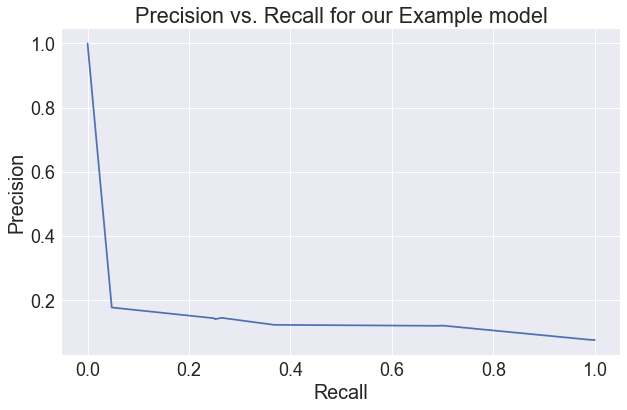

In [293]:
# first, let's plot precision vs recall
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(recall_curve, precision_curve)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision vs. Recall for our Example model')
plt.show()

That's pretty crap `¯\_(ツ)_/¯`

Next, let's plot the two curves against the percentage of businesses that would be labelled as positive.

In [300]:
def plot_precision_recall_n(y_true, y_prob, model_name, **kwargs): # kwargs to the rescue
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots(**kwargs)
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('ratio of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf()

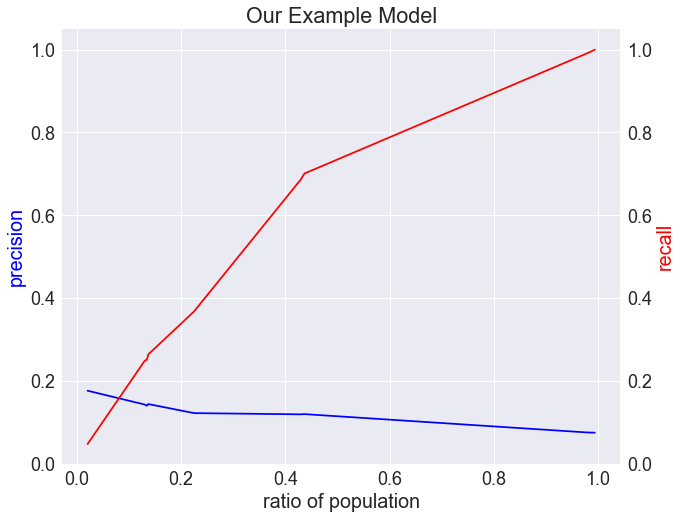

In [301]:
plot_precision_recall_n(y_true=m_test.label,
                        y_prob=pred,
                        model_name='Our Example Model',
                        figsize=(10,8)) # <-- figsize is a kwarg now, we pass it through to the plotting function

In [299]:
m_test.shape

(17681, 6)

In [302]:
len(pr_thresholds)

12

**Questions**: We're predicting on 17,681 data points, yet the plots above have only 12 discrete values, which are the probability thresholds that sklearn gave us back. What's going on there? What's the problem with 'ranking' our businesses by predicted score, in this concrete example? Does this tell us something about your model (including out features)?